In [2]:
import config as c 
from src.data import CombiDataset,make_loader,downsampling
from src.data import * 
from src.model import Model 
from src.freia_funcs import * 
from src.utils import * 
from tqdm import tqdm 
import tifffile  
import os 
import pandas as pd 
import torch.nn.functional as F 
import cv2 
import matplotlib.pyplot as plt 

my_experiment


/usr/local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
xyz = tifffile.imread('../../Dataset/MVtecAD3D/bagel/train/good/xyz/000.tiff')
rgb = cv2.imread('../../Dataset/MVtecAD3D/bagel/train/good/rgb/000.png')

In [25]:
print(f"origianl shape : {xyz.shape}")
# z axis extract
z = xyz[:,:,-1]
print(f"z axis extract : {z.shape}")

#fill gaps 
for _ in range(c.n_fills):
    z = fill_gaps(z)
print(f"fill gaps shape : {z.shape}")    

#foreground extract 
fg = remove_background(z,c.bg_thresh)
print(f"foreground extract {fg.shape}")

#foreground masking 
depth = z.copy()
mean_fg = np.sum(fg * depth) / np.sum(fg)
depth = fg * depth + (1 - fg) * mean_fg
depth = (depth - mean_fg) * 100
print(f"foreground masking : {depth.shape}")

# transform 
depth = torch.FloatTensor(depth)
if len(depth.shape) == 2:
    depth = depth[None,None]
    channels = 1 
print(depth.shape)    

# depth downsampling 
depth = F.interpolate(depth, size=c.depth_len, mode='bilinear', align_corners=False)
print(f"Downsampling : {depth.shape}")

# fg downsampling 
fg = torch.FloatTensor(fg)
if len(fg.shape) == 2:
    fg = fg[None,None]
fg = F.interpolate(fg, size=24, mode='bilinear', align_corners=False) 
print(f"Foreground shape : {fg.shape}")


# pixel unshuffle 
unshuffle = nn.PixelUnshuffle(c.depth_downscale)
depth = unshuffle(depth)
print(f"pixel unshuffle : {depth.shape}")

origianl shape : (800, 800, 3)
z axis extract : (800, 800)
fill gaps shape : (800, 800)
foreground extract (800, 800)
foreground masking : (800, 800)
torch.Size([1, 1, 800, 800])
Downsampling : torch.Size([1, 1, 192, 192])
Foreground shape : torch.Size([1, 1, 24, 24])
pixel unshuffle : torch.Size([1, 64, 24, 24])


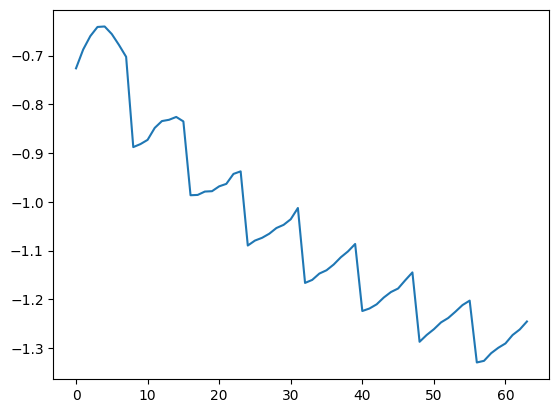

In [39]:
plt.plot(depth[0,:,13,12].numpy())